# Description of feature table

## Setup

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.utils import extract_color
from src.display_meta import display_diet_information

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams.update({"font.family": "DejaVu Sans"})
plt.style.use("tableau-colorblind10")

/cluster/project/bokulich/adamova/_conda_envs/preprocess_microbiome/lib/python3.9/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/cluster/project/bokulich/adamova/_conda_envs/preprocess_microbiome/lib/python3.9/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
# USER DEFINED variables
tag = "20240806"
tag_output = "entero_family"
path_to_data = "../data/final/"

# threshold for coloring microbiome samples after abx exposure
th_sample_after_abx_months = 1
# END USER DEFINED variables

In [3]:
# read processed feature table
path_to_ft = os.path.join(path_to_data, f"ft_vat19_anomaly_v{tag}_{tag_output}.tsv")
# read time-series of exact abx exposure data
path_to_abx = os.path.join(path_to_data, f"ts_vat19_abx_v{tag}.tsv")

# location to save all outputs of this notebook
path_to_output = os.path.join("../results", f"desc_{tag}_{tag_output}")
if not os.path.isdir(path_to_output):
    os.makedirs(path_to_output)

## Read datasets


In [4]:
# read and prep abx exposure data
abx_df = pd.read_csv(path_to_abx, sep="\t")
ls_abx_cols = ["host_id", "abx_start_age_months"]
abx_df = abx_df[ls_abx_cols].sort_values(ls_abx_cols).drop_duplicates()

In [5]:
# read and prep metadata
md_df = pd.read_csv(path_to_ft, sep="\t", index_col=0)

# columns for below plots
md_df = md_df.assign(
    sample_lt_xm_after_abx=lambda df: df["abx_any_last_t_dmonths"]
    <= th_sample_after_abx_months,
    max_abx_w_microbiome=lambda df: df.groupby("host_id")["abx_any_cumcount"].transform(
        "max"
    ),
)
md_df.sort_values(
    [
        "abx_max_count_ever",
        "max_abx_w_microbiome",
        "host_id",
        "age_months_rounded05",
    ],
    ascending=[True, True, True, True],
    inplace=True,
)

In [6]:
# sort abx_df in same order and remove samples that don't exist in md_df
abx_events = pd.DataFrame()
abx_events["host_id"] = md_df["host_id"].unique()
abx_events = pd.merge(abx_events, abx_df, on="host_id", how="left")
del abx_df
assert abx_events.host_id.unique().tolist() == md_df.host_id.unique().tolist()

In [7]:
def filter_both_dfs(md_df, abx_events, condition):
    md_df_filtered = md_df.groupby("host_id").filter(condition).copy()
    abx_events_filtered = abx_events[
        abx_events["host_id"].isin(md_df_filtered.host_id.unique())
    ].copy()
    return md_df_filtered, abx_events_filtered


# separate abx and no abx
md_df_noabx = md_df[md_df["max_abx_w_microbiome"] == 0].copy()
abx_events_noabx = abx_events[
    abx_events["host_id"].isin(md_df_noabx.host_id.unique())
].copy()

md_df_abx = md_df[md_df["max_abx_w_microbiome"] > 0].copy()
assert md_df_noabx.shape[0] + md_df_abx.shape[0] == md_df.shape[0]


# distinguish between invisible and visible abx with this threshold
invisible_condition = lambda x: all(~x["sample_lt_xm_after_abx"])
md_df_abx_invisible, abx_events_abx_invisible = filter_both_dfs(
    md_df_abx, abx_events, invisible_condition
)

visible_condition = lambda x: any(x["sample_lt_xm_after_abx"])
md_df_abx_visible, abx_events_abx_visible = filter_both_dfs(
    md_df_abx, abx_events, visible_condition
)

assert md_df_abx_invisible.shape[0] + md_df_abx_visible.shape[0] == md_df_abx.shape[0]

## Visualize overview of samples and abx events

In [8]:
# fraction of "visible" abx samples from all available microbiome samples
all_samples = md_df.shape[0]

frac_abx = 100 * (md_df["sample_lt_xm_after_abx"] == True).sum() / all_samples

print(f"Fraction of potentially abx influenced samples: {frac_abx:.2f} %")

Fraction of potentially abx influenced samples: 9.02 %


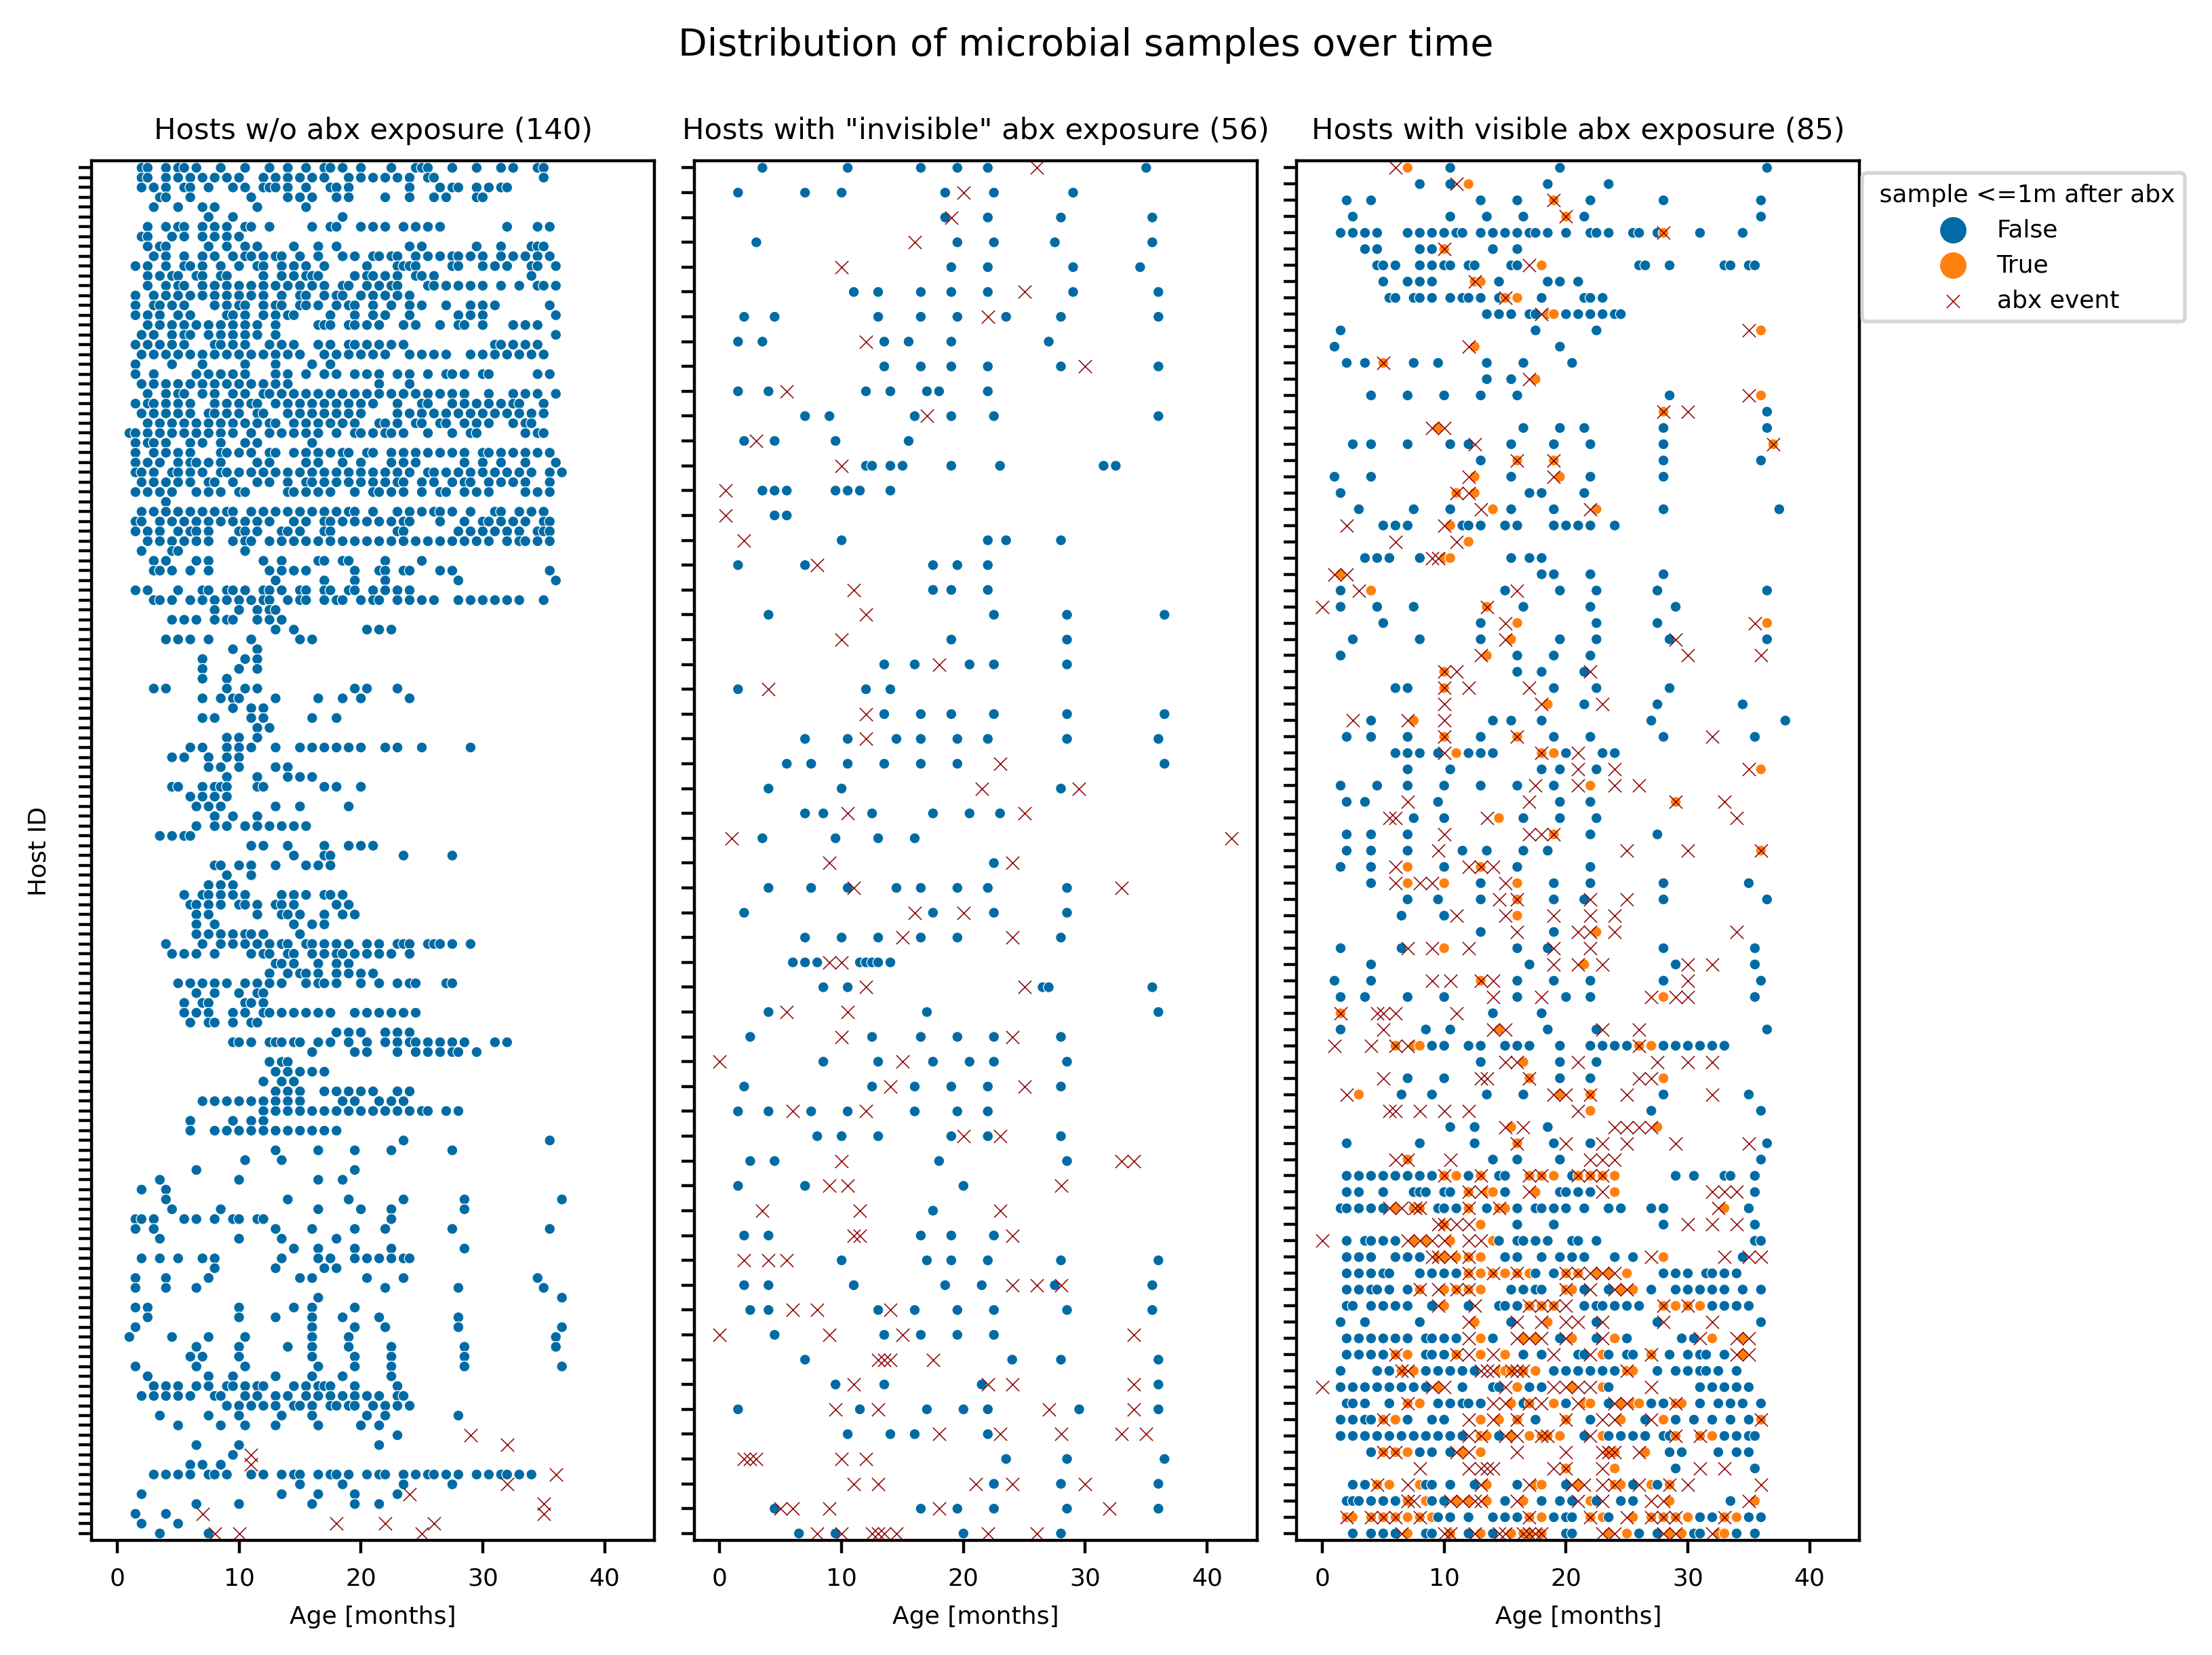

In [9]:
hide_ylabel_thickmarks = True  # hiding thickmarks of y-axis for slides
if hide_ylabel_thickmarks:
    plt.rcParams.update({"font.size": 6.5})
    fig, axs = plt.subplots(1, 3, figsize=(8, 6), sharex=True, dpi=400)
    markersize = 8
else:
    plt.rcParams.update({"font.size": 6})
    fig, axs = plt.subplots(1, 3, figsize=(9, 10), sharex=True, dpi=400)
    markersize = 10

dic_to_plot = {
    "w/o": [md_df_noabx, abx_events_noabx],
    'with "invisible"': [md_df_abx_invisible, abx_events_abx_invisible],
    "with visible": [md_df_abx_visible, abx_events_abx_visible],
}
i = 0

for title, df in dic_to_plot.items():
    # samples
    sns.scatterplot(
        x="age_months_rounded05",
        y="host_id",
        hue="sample_lt_xm_after_abx",
        data=df[0],
        ax=axs[i],
        s=markersize,
    )
    # abx events
    sns.scatterplot(
        x="abx_start_age_months",
        y="host_id",
        data=df[1],
        ax=axs[i],
        s=markersize * 1.5,
        marker="x",
        color="darkred",
        label="abx event",
    )

    axs[i].set_title(f"Hosts {title} abx exposure ({df[0].host_id.nunique()})")
    axs[i].set_xlabel("Age [months]")
    axs[i].set_ylabel("Host ID")
    axs[i].margins(y=0.005)
    if i != 0:
        axs[i].set_ylabel("")
    if i != 2:
        axs[i].get_legend().remove()
    if hide_ylabel_thickmarks:
        axs[i].set_yticklabels([])
    i += 1

axs[2].legend(
    loc="upper right",
    bbox_to_anchor=(1.60, 1),
    title=f" sample <={th_sample_after_abx_months}m after abx",
)
plt.suptitle("Distribution of microbial samples over time", fontsize=10, y=1.0)
plt.tight_layout()
filename = os.path.join(
    path_to_output,
    f"overall_distribution_samples_t{hide_ylabel_thickmarks}.png",
)
plt.savefig(filename, dpi=400, bbox_inches="tight")
plt.show()

A cross-sectional only publication found that abx effect was only detectable until 30 days after exposure in infants [source](https://www.nature.com/articles/s41467-023-44289-6). So threshold <= 1 month seems most promising (but we need to keep in mind that our study is longitudinal - and might reveal more detailed dynamics).

Unique host counts for different thresholds:

| <= `x` m after abx | # no abx | # invisible abx | # visible abx | # detectable samples [1] |
|--------------------|----------|-----------------|---------------|--------------------------|
| 1                  | 140      | 56              | 85            | 169                      |
| 2                  | "        | 34              | 107           |                          |
| 3                  | "        | 26              | 115           |                          |
| 4                  | "        | 21              | 120           |                          |
| 5                  | "        | 19              | 122           |                          |
| 6                  | "        | 17              | 124           |                          |
| 9                  | "        | 6               | 135           |                          |
| 12                 | "        | 2               | 139           |                          |

[1] Detectable samples are samples where samples were collected <= bellow threshold but not in same month as abx was given:
````
df[np.logical_and(
    df["abx_any_last_t_dmonths"]<= th_sample_after_abx_months,
    df["abx_any_last_t_dmonths"]>0
)].shape[0]
````

In [10]:
# # number of unique samples that were collected <= 1m after abx exposure but not in same month
# for th in [1, 2, 3, 4, 5, 6, 9, 12]:
#     print(th)

#     print(df[np.logical_and(
#         df["abx_any_last_t_dmonths"]<= th,
#         df["abx_any_last_t_dmonths"]>0
#     )].shape[0])
#     print()

## Visualize distribution of samples available 

In [11]:
def plot_box_violin(y, color, ax):
    violin = sns.violinplot(y=y, inner=None, ax=ax, color=color)

    box = sns.boxplot(
        y=y,
        width=0.1,
        boxprops={"facecolor": "white", "edgecolor": "black", "zorder": 2},
        flierprops={
            "marker": "o",
            "markerfacecolor": "none",
            "markeredgecolor": "black",
        },
        ax=ax,
    )

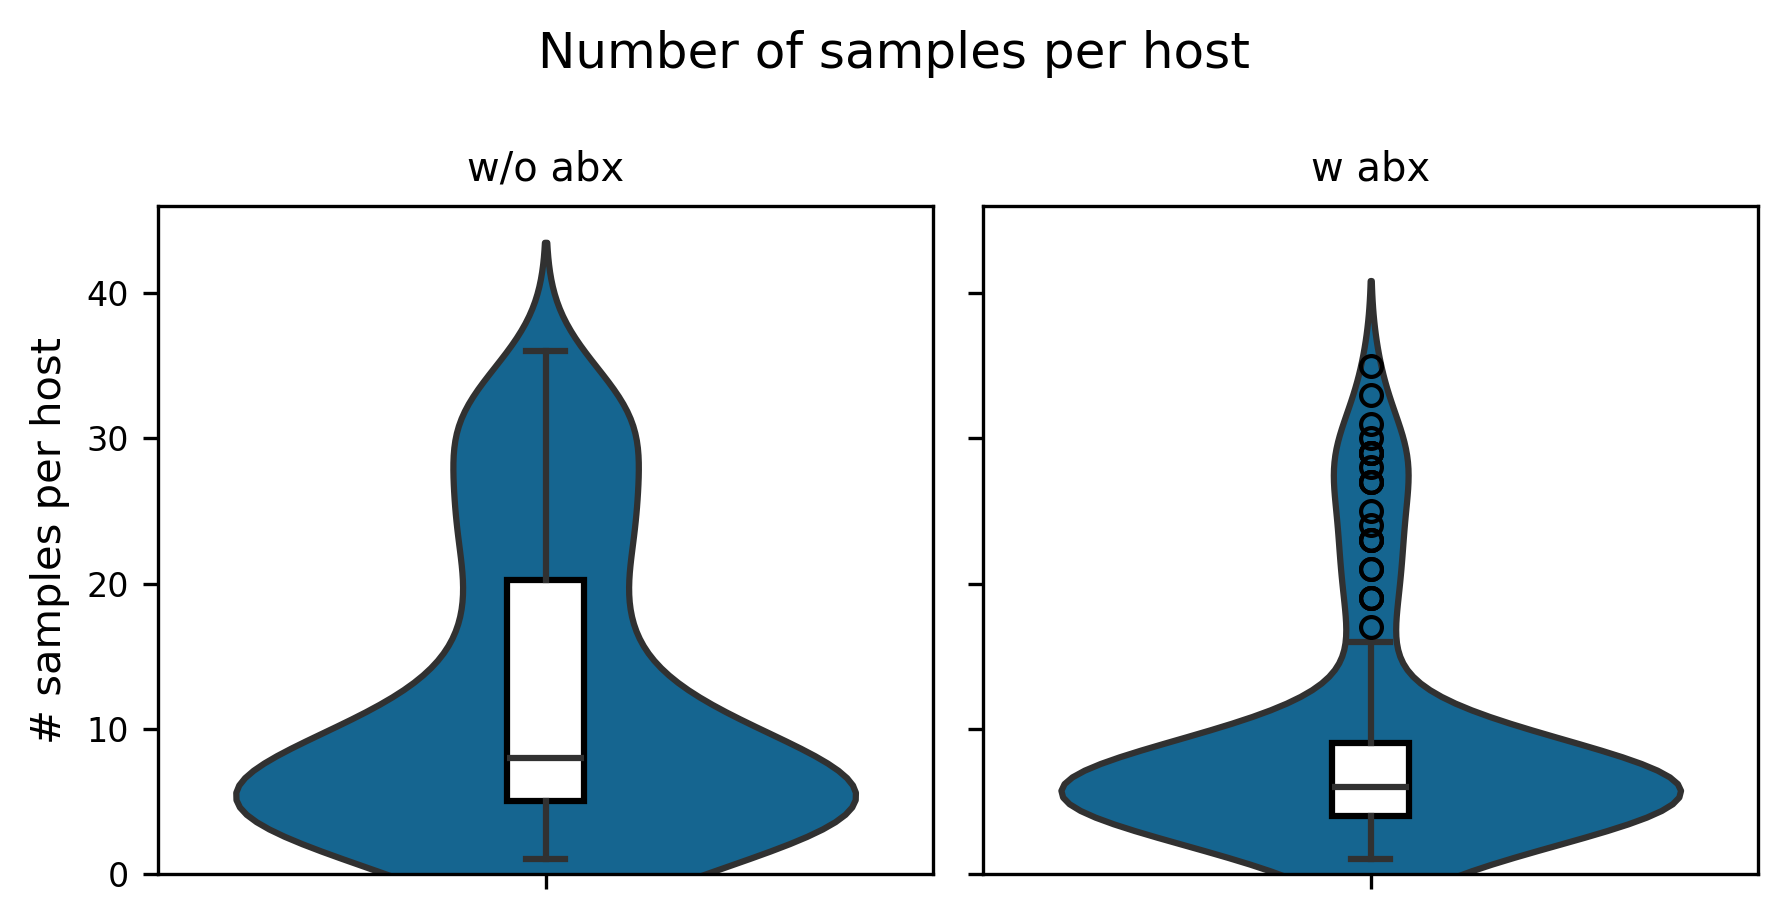

In [12]:
plt.rcParams.update({"font.family": "DejaVu Sans", "font.size": 8})
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True, dpi=300)

dic_to_plot = {
    "w/o abx": md_df_noabx,
    "w abx": md_df_abx,
    # 'with "invisible" abx': md_df_abx_invisible,
    # "with visible abx": md_df_abx_visible,
}
i = 0

for title, df in dic_to_plot.items():
    samples_per_host = df.groupby("host_id")["age_days"].agg("count")
    c = extract_color("tableau-colorblind10", 0)
    plot_box_violin(samples_per_host, c, axs[i])

    axs[i].set_title(title)
    axs[i].set_ylabel("")
    axs[i].set_ylim(bottom=0)
    i += 1
axs[0].set_ylabel("# samples per host", fontsize=10)
plt.suptitle("Number of samples per host", fontsize=12, y=1.0)
plt.tight_layout()
filename = os.path.join(path_to_output, "nb_samples_per_host.png")
plt.savefig(filename, dpi=400, bbox_inches="tight")
plt.show()

## Visualize first abx exposure

In [13]:
# how many samples are there in visible abx hosts with sample after 1st infant's abx exposure?
ls_cols = [
    "host_id",
    "age_months_rounded05",
    "abx_any_cumcount",
    "sample_lt_xm_after_abx",
    "abx_any_last_t_dmonths",
]
all_abx = md_df_abx.host_id.nunique()

# count the number of hosts with a microbial sample after their first abx exposure
first_abx_exp_sample = (md_df_abx["abx_any_cumcount"] == 1.0) & (
    md_df_abx_visible["sample_lt_xm_after_abx"] == True
)
num_hosts = md_df_abx.loc[
    first_abx_exp_sample,
    "host_id",
].nunique()

print(
    f"Of the \033[1m{all_abx}\033[0m hosts with abx exposure,"
    f" \033[1m{round(100*num_hosts/all_abx,1)} % ({num_hosts}\033[0m)"
    " have a sample after their first abx exposure."
)

Of the 141 hosts with abx exposure, 37.6 % (53) have a sample after their first abx exposure.


(53, 1)
Mean age: 11.94 months


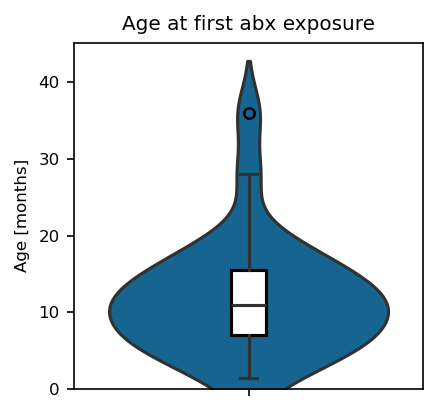

In [14]:
# What's the average age of hosts at first abx exposure? > 12.25 months
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)

first_abx = (
    md_df_abx.loc[first_abx_exp_sample, ["host_id", "age_months_rounded05"]]
    .groupby("host_id")
    .first()
)
print(first_abx.shape)
print(f"Mean age: {first_abx['age_months_rounded05'].mean():.2f} months")
plot_box_violin(first_abx["age_months_rounded05"], c, ax)
ax.set_ylabel("Age [months]")
ax.set_ylim(bottom=0)
ax.set_title(f"Age at first abx exposure")
plt.show()

## Display diet covariate

<Axes: xlabel='age_months_rounded1', ylabel='count of samples'>

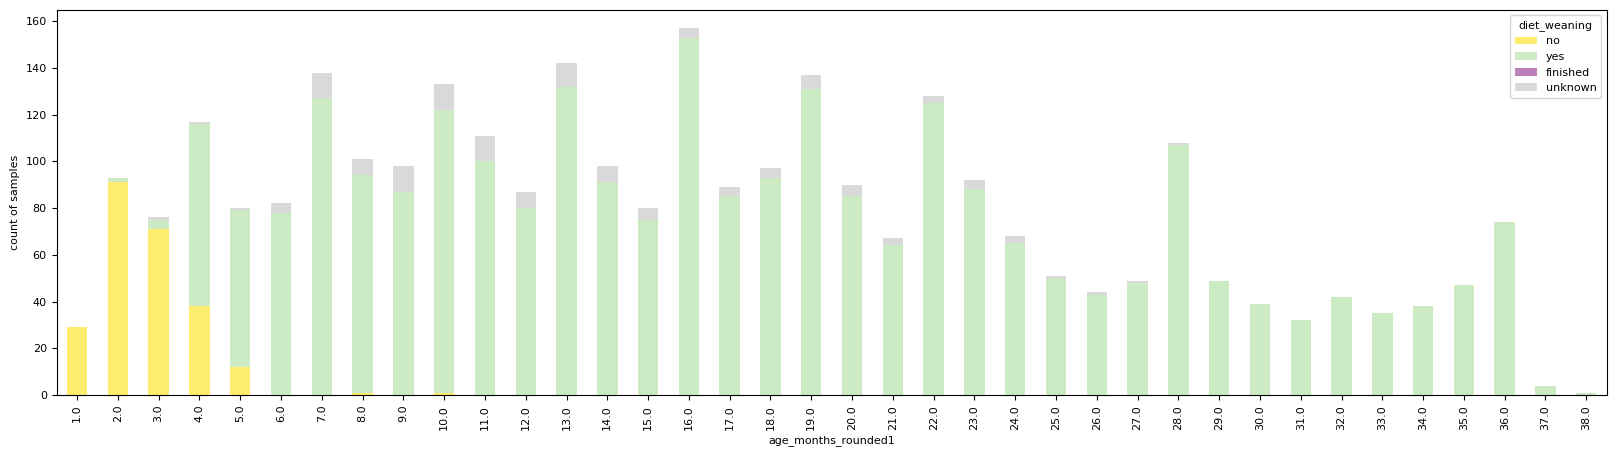

In [15]:
display_diet_information(md_df, "diet_weaning", "age_months_rounded1", "samples")

<Axes: xlabel='age_months_rounded1', ylabel='count of samples'>

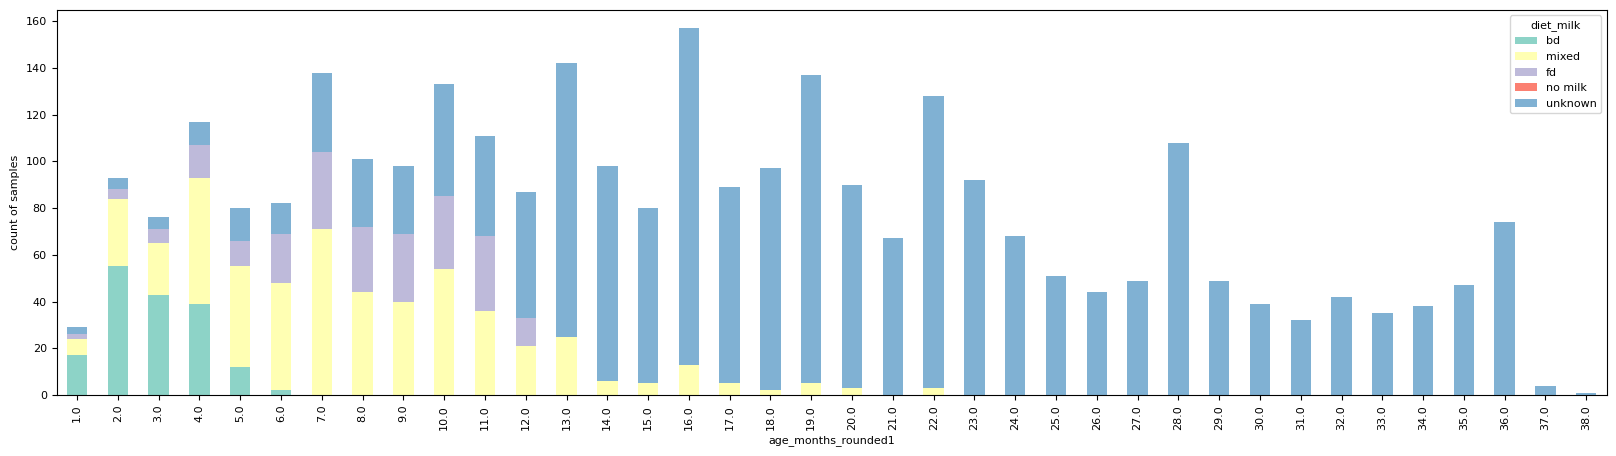

In [16]:
display_diet_information(md_df, "diet_milk", "age_months_rounded1", "samples")

## Check delivery mode and geolocation counts


In [17]:
md_df[["host_id", "delivery_mode"]].drop_duplicates().groupby("delivery_mode").count()

,host_id
delivery_mode,
cesarean,27
vaginal,254


In [18]:
md_df[["host_id", "geo_location_name"]].drop_duplicates().groupby(
    "geo_location_name"
).count()

,host_id
geo_location_name,
Estonia,77
Finland,132
Russia,72


## Check duration between samples (all hosts)

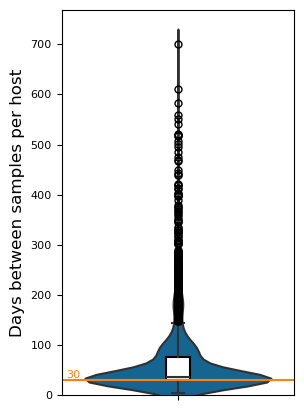

count    2722.000000
mean       66.226304
std        74.611833
min         3.000000
25%        29.000000
50%        35.000000
75%        75.000000
max       700.000000
Name: diff_age, dtype: float64

In [19]:
# get number of days between samples of an infant:
cols = ["host_id", "age_days"]
df_md_diff = md_df[cols].sort_values(cols)
df_md_diff["diff_age"] = df_md_diff[cols].sort_values(cols).groupby(["host_id"]).diff()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 5))
c = extract_color("tableau-colorblind10", 0)
plot_box_violin(df_md_diff["diff_age"], c, ax)

ax.set_ylabel("Days between samples per host", fontsize=12)
ax.set_ylim(0)
c_thirty = extract_color("tableau-colorblind10", 1)
ax.axhline(y=30, color=c_thirty)
ax.text(x=-0.48, y=33, s="30", color=c_thirty)
plt.show()

df_md_diff["diff_age"].describe()

## Derive time of initial sample per "noabx" host


(originally used to define imputation for initial samples of noabx hosts)

### Time of initial sample per "noabx" host

In [20]:
first_sample = md_df_noabx[["age_days", "host_id"]].groupby("host_id").min()
first_sample.describe()

,age_days
count,140.000000
mean,172.207143
std,137.970672
min,30.000000
25%,60.750000
50%,130.500000
75%,230.500000
max,713.000000


Text(0.5, 1.0, 'Age of first sample per noabx host')

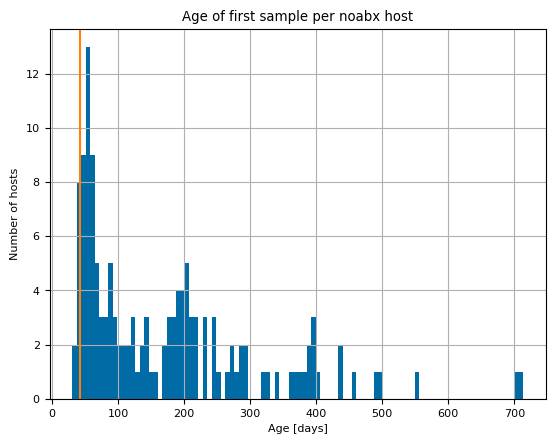

In [21]:
first_sample.hist(bins=100)
plt.axvline(x=42, color=c_thirty)
plt.ylabel("Number of hosts")
plt.xlabel("Age [days]")
plt.title("Age of first sample per noabx host")

(0.0, 860.1253913206949)

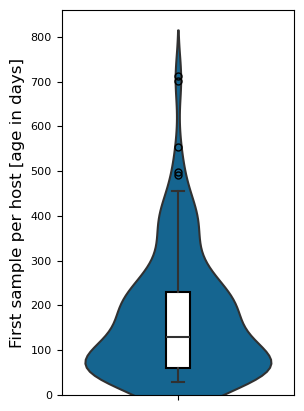

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 5))
c = extract_color("tableau-colorblind10", 0)
plot_box_violin(first_sample["age_days"], c, ax)
ax.set_ylabel("First sample per host [age in days]", fontsize=12)
ax.set_ylim(0)

### Noabx hosts that have samples prior or at 42 days 

(originally used to suggest new t0)

In [23]:
early_noabx_samples = md_df_noabx.loc[
    md_df_noabx["age_days"] <= (35 + 7), ["host_id", "age_days"]
]
early_noabx_samples

,host_id,age_days
SRR8119040,E016063,40
SRR8118924,E017751,30
SRR8119044,E018286,40
SRR8119215,E021032,41
SRR8120152,T012808,39
SRR8115843,T012983,39
SRR8120787,T016812,39
SRR8115878,T019850,35


In [24]:
# how many unique noabx hosts do we have <= 42 days?
init_hosts = md_df_noabx.loc[md_df_noabx["age_days"] <= (35 + 7), "host_id"].unique()
len(init_hosts)

8

In [25]:
# delivery mode of noabx hosts with samples at t0=42 days
init_host_delmode = md_df_noabx.loc[
    md_df_noabx["host_id"].isin(init_hosts), ["host_id", "delivery_mode"]
].drop_duplicates()
init_host_delmode["delivery_mode"].value_counts()

delivery_mode
vaginal     6
cesarean    2
Name: count, dtype: int64

### Noabx host samples missed with t0=42 days

In [26]:
# how many unique abx hosts do we have < 42 days?
# -> we would miss those by setting t0=42 days
abx_init_hosts = md_df_abx.loc[md_df_abx["age_days"] < (28 + 2 * 7), "host_id"].unique()
len(abx_init_hosts)

6

### Abx hosts with antibiotics exposure at birth

In [27]:
cond_birth_abx = (
    md_df_abx["age_months_rounded05"] - md_df_abx["abx_any_last_t_dmonths"]
) == 0.0

hosts_wabx_at_birth = md_df_abx.loc[cond_birth_abx, "host_id"].unique()
print(f"# hosts with ABX exposure at birth: {len(hosts_wabx_at_birth)}")

# hosts with ABX exposure at birth: 5


In [28]:
md_df_abx.loc[cond_birth_abx, "delivery_mode"].unique()

array(['vaginal'], dtype=object)

All of these hosts were vaginally born.

In [29]:
# do we have early microbial samples for these hosts at birth?
# -> only 1 host has sample at t0=42 days

md_df_abx.loc[
    md_df_abx["host_id"].isin(hosts_wabx_at_birth),
    ["host_id", "age_days", "abx_max_count_ever", "delivery_mode"],
].groupby("host_id").min()

,age_days,abx_max_count_ever,delivery_mode
host_id,,,
E016426,42,9.0,vaginal
E021235,68,7.0,vaginal
T012312,252,2.0,vaginal
T012374,130,4.0,vaginal
T013832,44,2.0,vaginal
